# Creating features and target

## import packages and DataFrame

In [1]:
from features import Dataframe
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import RobustScaler
from sklearn.inspection import permutation_importance
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import train_test_split, HalvingGridSearchCV
import warnings
warnings.filterwarnings('ignore')

In [2]:
polkadot = Dataframe().get_dataframe()

In [3]:
polkadot.head()

,date,current_price,current_price_sats,market_cap,reddit_post_48h,reddit_comment_48h,reddit_subscribers,reddit_active_accounts,public_interest_stats,Value,Value_classification
0,2020-08-23,4.481389,38367.856477,4.028277e+09,1.091,5.364,313,16.500000,NaN,76,Extreme Greed
1,2020-08-24,3.966083,34041.816539,3.630431e+09,0.636,3.636,368,47.500000,NaN,78,Extreme Greed
2,2020-08-25,4.576939,38926.351643,4.162345e+09,3.364,10.091,3466,87.250000,NaN,75,Greed
3,2020-08-26,5.493947,48405.452250,4.910961e+09,3.182,15.818,3585,133.166667,NaN,76,Extreme Greed
4,2020-08-27,6.067730,52928.412025,5.508438e+09,1.364,12.545,3753,171.583333,NaN,75,Greed


## create target

> create price in two days as target, then convert that into 0 (price less than the day before)
or 1 (price more than the day before)

In [4]:
polkadot['predict'] = polkadot['current_price'].shift(-2)

In [5]:
polkadot['predict'] = pd.Series(np.where(polkadot['predict'].values < polkadot['current_price'], 0, 1),
          polkadot.index)

## create new features

In [6]:
polkadot['price_ema5'] = polkadot['current_price'].ewm(span=5, adjust=False).mean()
polkadot['price_ema20'] = polkadot['current_price'].ewm(span=20, adjust=False).mean()
polkadot['price_ema50'] = polkadot['current_price'].ewm(span=50, adjust=False).mean()

polkadot['fear_ema5'] = polkadot['Value'].ewm(span=2, adjust=False).mean()
polkadot['fear_ema20'] = polkadot['Value'].ewm(span=20, adjust=False).mean()
polkadot['fear_ema50'] = polkadot['Value'].ewm(span=50, adjust=False).mean()

polkadot['fear_change_2_days'] = polkadot['Value'] - polkadot['Value'].shift(2)
polkadot['fear_change_1_week'] = polkadot['Value'] - polkadot['Value'].shift(7)
polkadot['fear_change_2_weeks'] = polkadot['Value'] - polkadot['Value'].shift(14)

polkadot['reddit_post_ema5'] = polkadot['reddit_post_48h'].ewm(span=5, adjust=False).mean()
polkadot['reddit_post_ema20'] = polkadot['reddit_post_48h'].ewm(span=20, adjust=False).mean()
polkadot['reddit_post_ema50'] = polkadot['reddit_post_48h'].ewm(span=50, adjust=False).mean()

polkadot['reddit_change_2_days'] = polkadot['reddit_post_48h'] - polkadot['reddit_post_48h'].shift(2)
polkadot['reddit_change_1_week'] = polkadot['reddit_post_48h'] - polkadot['reddit_post_48h'].shift(7)
polkadot['reddit_change_2_weeks'] = polkadot['reddit_post_48h'] - polkadot['reddit_post_48h'].shift(14)

polkadot['sats_ema5'] = polkadot['current_price_sats'].ewm(span=5, adjust=False).mean()
polkadot['sats_ema20'] = polkadot['current_price_sats'].ewm(span=20, adjust=False).mean()
polkadot['sats_ema50'] = polkadot['current_price_sats'].ewm(span=50, adjust=False).mean()

polkadot['sats_change_2_days'] = polkadot['current_price_sats'] - polkadot['current_price_sats'].shift(2)
polkadot['sats_change_1_week'] = polkadot['current_price_sats'] - polkadot['current_price_sats'].shift(7)
polkadot['sats_change_2_weeks'] = polkadot['current_price_sats'] - polkadot['current_price_sats'].shift(14)

polkadot['price_change_2_days'] = polkadot['current_price'] - polkadot['current_price'].shift(2)
polkadot['price_change_1_week'] = polkadot['current_price'] - polkadot['current_price'].shift(7)
polkadot['price_change_2_weeks'] = polkadot['current_price'] - polkadot['current_price'].shift(14)

### inspect and fix na values

In [7]:
polkadot.isnull().sum()

date                       0
current_price              0
current_price_sats         0
market_cap                 0
reddit_post_48h            0
reddit_comment_48h         0
reddit_subscribers         0
reddit_active_accounts     0
public_interest_stats      8
Value                      0
Value_classification       0
predict                    0
price_ema5                 0
price_ema20                0
price_ema50                0
fear_ema5                  0
fear_ema20                 0
fear_ema50                 0
fear_change_2_days         2
fear_change_1_week         7
fear_change_2_weeks       14
reddit_post_ema5           0
reddit_post_ema20          0
reddit_post_ema50          0
reddit_change_2_days       2
reddit_change_1_week       7
reddit_change_2_weeks     14
sats_ema5                  0
sats_ema20                 0
sats_ema50                 0
sats_change_2_days         2
sats_change_1_week         7
sats_change_2_weeks       14
price_change_2_days        2
price_change_1

In [8]:
polkadot[polkadot['public_interest_stats'].isnull()] = 0
polkadot[polkadot['fear_change_2_days'].isnull()] = 0
polkadot[polkadot['fear_change_1_week'].isnull()] = 0
polkadot[polkadot['fear_change_2_weeks'].isnull()] = 0
polkadot[polkadot['reddit_change_2_days'].isnull()] = 0
polkadot[polkadot['reddit_change_1_week'].isnull()] = 0
polkadot[polkadot['reddit_change_2_weeks'].isnull()] = 0
polkadot[polkadot['sats_change_2_days'].isnull()] = 0
polkadot[polkadot['sats_change_1_week'].isnull()] = 0
polkadot[polkadot['sats_change_2_weeks'].isnull()] = 0
polkadot[polkadot['price_change_2_days'].isnull()] = 0
polkadot[polkadot['price_change_1_week'].isnull()] = 0
polkadot[polkadot['price_change_2_weeks'].isnull()] = 0

In [9]:
polkadot.isnull().sum()

date                      0
current_price             0
current_price_sats        0
market_cap                0
reddit_post_48h           0
reddit_comment_48h        0
reddit_subscribers        0
reddit_active_accounts    0
public_interest_stats     0
Value                     0
Value_classification      0
predict                   0
price_ema5                0
price_ema20               0
price_ema50               0
fear_ema5                 0
fear_ema20                0
fear_ema50                0
fear_change_2_days        0
fear_change_1_week        0
fear_change_2_weeks       0
reddit_post_ema5          0
reddit_post_ema20         0
reddit_post_ema50         0
reddit_change_2_days      0
reddit_change_1_week      0
reddit_change_2_weeks     0
sats_ema5                 0
sats_ema20                0
sats_ema50                0
sats_change_2_days        0
sats_change_1_week        0
sats_change_2_weeks       0
price_change_2_days       0
price_change_1_week       0
price_change_2_weeks

In [10]:
polkadot[polkadot['public_interest_stats'].isnull()] = 0

In [11]:
df = Dataframe().get_features(forecast_out=7)

## find features and model

### create features and target

In [12]:
X = df.drop(columns=['predict', 'date', 'Value_classification'])
y = df['predict']

### use RobustScaler to scale features

In [13]:
scaler = RobustScaler().fit(X)
X_scaled = scaler.transform(X)

### use feature permutation to find most important features

> need to remove highly correlated entries

In [14]:
regressor = KNeighborsClassifier().fit(X_scaled, y)
permutation_score = permutation_importance(regressor, X_scaled, y, n_repeats=10)
importance_df = pd.DataFrame(np.vstack((X.columns,
                                        permutation_score.importances_mean)).T)
importance_df.columns=['feature','score decrease']

importance_df['score decrease'] = abs(importance_df['score decrease'])
importance_df = importance_df.sort_values(by="score decrease", ascending = False)

In [15]:
features = importance_df['feature']

In [16]:
importance_df.head()

,feature,score decrease
15,fear_change_2_days,0.037255
29,sats_change_2_weeks,0.021212
23,reddit_change_2_weeks,0.019073
28,sats_change_1_week,0.018895
27,sats_change_2_days,0.016043


### test different classifiers

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [18]:
k_regressor = KNeighborsClassifier().fit(X_train, y_train)
s_model = SVC().fit(X_train, y_train)
classifier = DecisionTreeClassifier().fit(X_train, y_train)
random_classifier = RandomForestClassifier().fit(X_train, y_train)
ada = AdaBoostClassifier().fit(X_train, y_train)
gradient = GradientBoostingClassifier().fit(X_train, y_train)

In [19]:
scores = pd.DataFrame(columns=['scores'], index=['KNeighbors', 'Support Vector', 'Decision Tree',
                                                'Random Forest', 'Ada Boost', 'Gradient Boost'], 
                      data=[k_regressor.score(X_test, y_test), s_model.score(X_test, y_test),
                           classifier.score(X_test, y_test), random_classifier.score(X_test, y_test),
                           ada.score(X_test, y_test), gradient.score(X_test, y_test)])

In [20]:
scores

,scores
KNeighbors,0.646018
Support Vector,0.637168
Decision Tree,0.787611
Random Forest,0.840708
Ada Boost,0.761062
Gradient Boost,0.814159


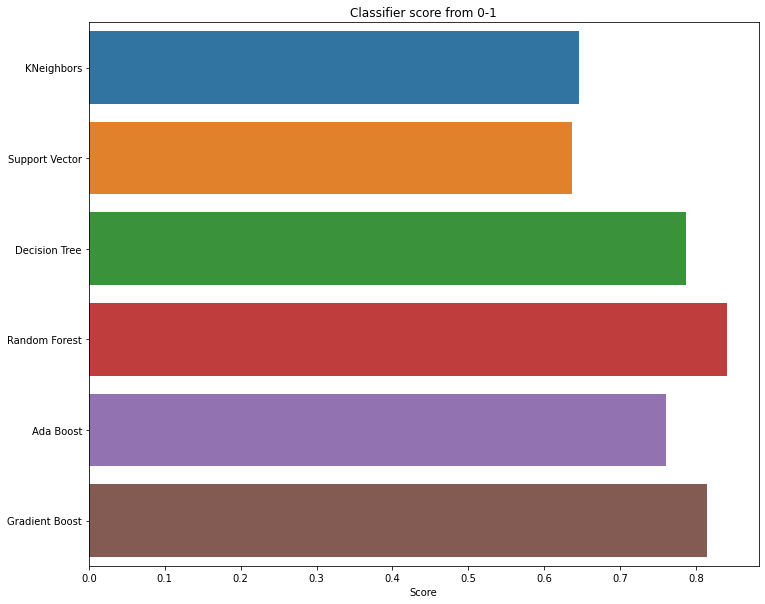

In [21]:
plt.figure(figsize=(12,10))
sns.barplot(y=scores.index, x=scores['scores'])
plt.xlabel('Score')
plt.title('Classifier score from 0-1');

In [22]:
from utils import Utils

In [23]:
classifiers = Utils().test_classifiers(X_scaled, y)

In [24]:
classifiers

,scores
KNeighbors,0.680473
Support Vector,0.686391
Decision Tree,0.769231
Random Forest,0.816568
Ada Boost,0.751479
Gradient Boost,0.781065


> Let's experiment more with RandomForestClassifier to see if we can improve results

# Random Forest Classifier

### use HalvingGridSearchCV to find optimal parameters

In [25]:
clf_test = RandomForestClassifier(random_state=42)


In [26]:
param_distributions = {"max_depth": [None, 5, 10, 20, 40],
                      'max_features': ['auto', 'sqrt', 'log2'],
                      'criterion':['gini', 'entropy']}

In [27]:
hrs_cv = HalvingGridSearchCV(estimator=clf_test, param_grid=param_distributions, random_state=42).fit(X_test, y_test)

In [28]:
hrs_cv.best_params_

{'criterion': 'entropy', 'max_depth': 10, 'max_features': 'sqrt'}

In [29]:
max_features=hrs_cv.best_params_['max_features']
max_depth=hrs_cv.best_params_['max_depth']
criterion=hrs_cv.best_params_['criterion']

In [30]:
clf = RandomForestClassifier(random_state=42, max_features=max_features,
                            max_depth=max_depth, criterion=criterion).fit(X_train, y_train)

In [31]:
clf.score(X_test, y_test)

0.7964601769911505

> fine-tuning parameters provided little difference in the score.
> attempt fine-tuning Gradient-Boosting to see if score can be improved

# Gradient Boosting

> base score of GradientBoostingClassifier was 0.772727

In [32]:
gb_test = GradientBoostingClassifier(random_state=42)

In [33]:
param_grid = {'loss': ['deviance', 'exponential'],
             'learning_rate': [0.05, 0.1, 0.2, 0.4, 0.6],
              'criterion': ['friedman_mse', 'squared_error'],
              'max_features': ['auto', 'sqrt', 'log2', 0.13]}
              

In [34]:
hrs_gb = HalvingGridSearchCV(estimator=gb_test, param_grid=param_grid, random_state=42).fit(X_test, y_test)

In [35]:
max_features=hrs_gb.best_params_['max_features']
loss=hrs_gb.best_params_['loss']
criterion=hrs_gb.best_params_['criterion']
learning_rate=hrs_gb.best_params_['learning_rate']

In [36]:
gb = GradientBoostingClassifier(random_state=42, max_features=max_features, loss=loss, 
                                criterion=criterion, learning_rate=learning_rate).fit(X_train, y_train)

In [37]:
gb.score(X_test, y_test)

0.7699115044247787

# Analyse effectiveness of models

### check distribution of target

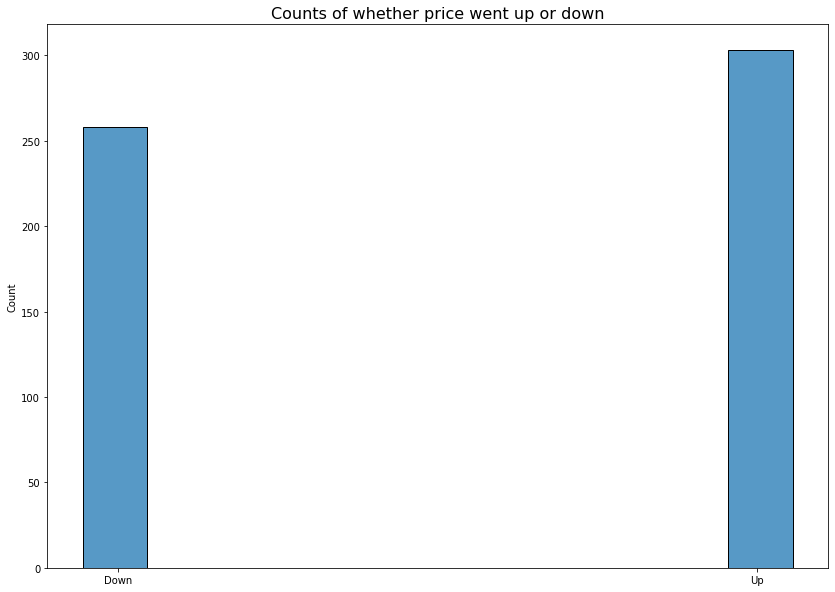

In [38]:
plt.figure(figsize=(14,10))
sns.histplot(y)
plt.xticks(ticks=[0.05, 0.95], labels=['Down', 'Up'])
plt.xlabel('')
plt.title('Counts of whether price went up or down',
         fontsize=16);

In [39]:
y_test_pred = clf.predict(X_test)

In [40]:
y_train_pred = clf.predict(X_train)

In [41]:
y_total_pred = clf.predict(X_scaled)

### classification report for training set

In [42]:
print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       213
           1       1.00      1.00      1.00       235

    accuracy                           1.00       448
   macro avg       1.00      1.00      1.00       448
weighted avg       1.00      1.00      1.00       448



### classification report for entire set

In [43]:
print(classification_report(y, y_total_pred))

              precision    recall  f1-score   support

           0       0.95      0.96      0.96       258
           1       0.97      0.96      0.96       303

    accuracy                           0.96       561
   macro avg       0.96      0.96      0.96       561
weighted avg       0.96      0.96      0.96       561



### classification report for test set

In [44]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.73      0.78      0.75        45
           1       0.85      0.81      0.83        68

    accuracy                           0.80       113
   macro avg       0.79      0.79      0.79       113
weighted avg       0.80      0.80      0.80       113



> The recall and precision balance is useful for me, personally, as it leans towards being riskier

# Add features and test performance

# Remove features and test performance

### write function to remove features until the best score is found

In [45]:
def remove_features(X, y, features):
    scores = list()
    while len(X.columns) > 1:
        scaler = RobustScaler().fit(X)
        X_scaled = scaler.transform(X)
        X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
        clf = RandomForestClassifier(random_state=42, max_features='sqrt',
                            max_depth=40, criterion='entropy').fit(X_train, y_train)
        scores.append([len(X.columns), clf.score(X_test, y_test)])
        X = X.drop(columns=features.iloc[-1])
        features = features.iloc[:-1]
    scores = np.array(scores)
    idx = scores[:, 1].argmax()
    return scores

In [46]:
best_features = remove_features(X, y, features)

In [47]:
idx = best_features[:, 1].argmax()

In [48]:
f = list(features[:idx])

In [49]:
X = X[f]

In [50]:
scaler = RobustScaler().fit(X)
X_scaled = scaler.transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
clf = RandomForestClassifier(random_state=42, max_features='sqrt',
                             max_depth=40, criterion='entropy').fit(X_train, y_train)

In [51]:
pred = clf.predict(X_test)

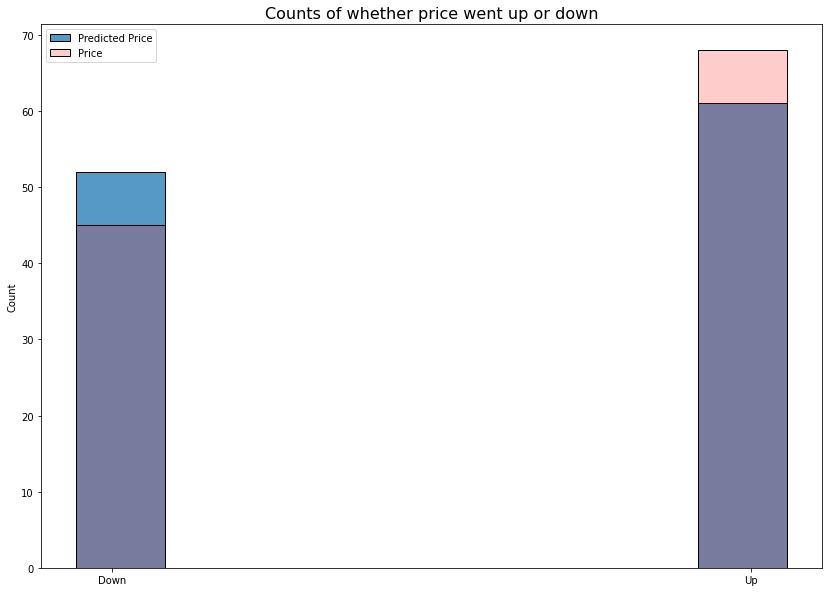

In [52]:
plt.figure(figsize=(14,10))
sns.histplot(pred, label='Predicted Price')
sns.histplot(y_test, color='r', alpha=0.2, label='Price')
plt.xticks(ticks=[0.05, 0.95], labels=['Down', 'Up'])
plt.xlabel('')
plt.title('Counts of whether price went up or down',
         fontsize=16);
plt.legend();

> We can see that our model has a tendency to over-choose 0 (price will go down)